# Supervised training for RANS flows around airfoils

## Overview

For this example of supervised training
we target turbulent airflows around wing profiles: the learned operator should provide the average motion
and pressure distribution around a given airfoil geometry for different Reynolds numbers and angles of attack.
Thus, inputs to the neural network are airfoil shape, Reynolds numbers, and angle of attack, and it should compute
a time averaged velocity field with 2 components, and the pressure field around the airfoil.

This is classically approximated with _Reynolds-Averaged Navier Stokes_ (RANS) models, and this
setting is still one of the most widely used applications of Navier-Stokes solvers in industry.
However, instead of relying on traditional numerical methods to solve the RANS equations,
we now aim for training a surrogate model via a neural network that completely bypasses the numerical solver.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/supervised-airfoils.ipynb)


## Formulation


With the supervised formulation from {doc}`supervised`, our learning task is pretty straight-forward, and can be written as

$$\begin{aligned}
\text{arg min}_{\theta} \sum_i ( f(x_i ; \theta)-y^*_i )^2 ,
\end{aligned}$$

where $x$ and $y^*$ each consist of a set of physical fields,
and the index $i$ evaluates the difference across all discretization points in our data sets.

The goal is to infer velocity $\mathbf{u} = u_x,u_y$ and a pressure field $p$ in a computational domain $\Omega$
around the airfoil in the center of $\Omega$.
$u_x,u_y$ and $p$ each have a dimension of $128^2$.
As inputs we have the Reynolds number $\text{Re} \in \mathbb{R}$, the angle of attack
$\alpha \in \mathbb{R}$, and the airfoil shape $\mathbf{s}$ encoded as a rasterized grid with $128^2$.
 $\text{Re}$ and $\alpha$ are provided in terms of the freestream flow velocity $\mathbf{f}$, the x and y components of which are represented as constant fields of the same size, and contain zeros in the airfoil region.
Thus, put together, both input and output have the same dimensions: $x,y^* \in \mathbb{R}^{3\times128\times128}$. The inputs contain
$[f_x,f_y,\text{mask}]$, while the outputs store the channels $[p,u_x,u_y]$.
This is exactly what we'll specify as input and output dimensions for the NN below.

A point to keep in mind here is that our quantities of interest in $y^*$ contain three different physical fields. While the two velocity components are quite similar in spirit, the pressure field typically has a different behavior with an approximately squared scaling with respect to the velocity (cf. [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli%27s_principle)). This implies that we need to be careful with simple summations (as in the minimization problem above), and that we should take care to normalize the data. If we don't take care, one of the components can dominate and the aggregation in terms of mean will lead the NN to spend more resources to learn the large component rather than the other ones causing smaller errors.


## Code coming up...

Let's get started with the implementation. Note that we'll skip the data generation process here. The code below is adapted from {cite}`thuerey2020dfp` and [this codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Below, we'll simply use a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/). First, let's import the required module, and install the dataloader from git.

In [1]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

!pip install --upgrade --quiet git+https://github.com/tum-pbs/pbdl-dataset
from pbdl.torch.loader import Dataloader

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


The next cell will download the training data from HuggingFace, which can take a moment... The PBDL dataloader call below directly splits it into 320 samples for training, and 80 samples for validation. These validation samples are using the same airfoil shapes as the training samples, but different conditions (later on we'll download new shapes for testing).

In [2]:
BATCH_SIZE = 10

loader_train, loader_val = Dataloader.new_split(
    [320, 80],
    "airfoils",
    batch_size=BATCH_SIZE, normalize_data=None,
)

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%
Success: Loaded airfoils with 400 simulations and 1 samples each.


## RANS training data

Now we have the training and validation data. In general it's very important to understand the data we're working with as much as possible (for any ML task the _garbage-in-gargabe-out_ principle definitely holds). We should at least understand the data in terms of dimensions and rough statistics, but ideally also in terms of content. Otherwise we'll have a very hard time interpreting the results of a training run. And despite all the _AI magic_: if you can't make out any patterns in your data, NNs most likely also won't find any useful ones.

Hence, let's look at one of the training samples. The following is just some helper code to show images side by side.

这个函数以后一定要有，用于检查数据集的输入和输出是否正确；深度学习中，垃圾进垃圾出的问题非常重要。

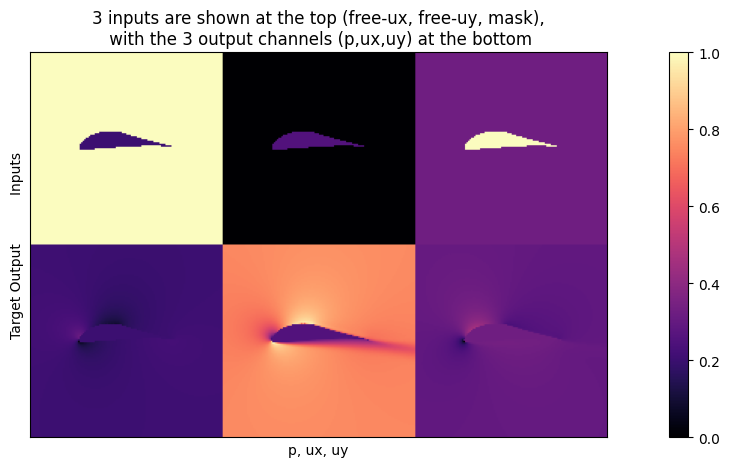

In [3]:
def plot(a1, a2, mask=None, stats=False, bottom="NN Output", top="Reference", title=None):
    c = []
    if mask is not None: mask = np.asarray(mask)
    for i in range(3):
        a2i = np.asarray(a2[i])
        if mask is not None: a2i = a2i - mask*a2i # optionally mask out inner region
        b = np.flipud(np.concatenate((a2i, a1[i]), axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b)
        if stats:
            print("Stats %d: " % i + format([min, mean, max]))
        b -= min
        b /= max - min
        c.append(b)
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]) ; axes.set_yticks([])
    im = axes.imshow(np.concatenate(c, axis=1), origin="upper", cmap="magma")
    fig.colorbar(im, ax=axes)
    axes.set_xlabel("p, ux, uy")
    axes.set_ylabel("%s           %s" % (bottom, top))
    if title is not None: plt.title(title)
    plt.show()

inputs, targets = next(iter(loader_train))
plot(inputs[0], targets[0], stats=False, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (free-ux, free-uy, mask),\n with the 3 output channels (p,ux,uy) at the bottom")


## Network setup

Now we can set up the architecture of our neural network, we'll use a fully convolutional U-net. This is a widely used architecture that uses a stack of convolutions across different spatial resolutions. The main deviation from a regular conv-net is the hierarchy (for a global receptive field), and to introduce _skip connections_ from the encoder to the decoder part. This ensures that no information is lost during feature extraction. (Note that this only works if the network is to be used as a whole. It doesn't work in situations where we'd, e.g., want to use the decoder as a standalone component.)

Here's a overview of the architecure:

![An overview of the U-net we're using for this learning task](https://github.com/tum-pbs/pbdl-book/blob/main/resources/supervised-airfoils-unet.jpg?raw=1)

First, we'll define a helper to set up a convolutional block in the network, `blockUNet`. Note, we don't use any pooling! Instead we use strides and transpose convolutions (these need to be symmetric for the decoder part, i.e. have an uneven kernel size), following [best practices](https://distill.pub/2016/deconv-checkerboard/). The full pytroch neural network is managed via the `DfpNet` class.

这个blockNet也很有意思，可以用一个nn.Sequential来装入需要的模块，而模块具体需要什么，比如bn模块，转置模块等，可以通过函数的输入量来调整。

In [4]:
def blockUNet( in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0.0 ):

    block = nn.Sequential()

    if not transposed:
        block.add_module(
            "%s_conv" % name,
            nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True),
        )
    else:
        block.add_module(
            "%s_upsam" % name, nn.Upsample(scale_factor=2, mode="bilinear")
        )
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module(
            "%s_tconv" % name,
            nn.Conv2d( in_c, out_c, kernel_size=(size - 1), stride=1, padding=pad, bias=True ),
        )

    if bn:
        block.add_module("%s_bn" % name, nn.BatchNorm2d(out_c))
    if dropout > 0.0:
        block.add_module("%s_dropout" % name, nn.Dropout2d(dropout, inplace=True))

    if activation:
        if relu:
            block.add_module("%s_relu" % name, nn.ReLU(inplace=True))
        else:
            block.add_module("%s_leakyrelu" % name, nn.LeakyReLU(0.2, inplace=True))

    return block


class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.0):
        super(DfpNet, self).__init__()
        channels = int(2**channelExponent + 0.5)

        self.layer1 = blockUNet( 3,            channels * 1, "enc_layer1", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer2 = blockUNet( channels,     channels * 2, "enc_layer2", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer3 = blockUNet( channels * 2, channels * 2, "enc_layer3", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer4 = blockUNet( channels * 2, channels * 4, "enc_layer4", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer5 = blockUNet( channels * 4, channels * 8, "enc_layer5", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer6 = blockUNet( channels * 8, channels * 8, "enc_layer6", transposed=False, bn=True, relu=False, dropout=dropout, size=2, pad=0, )
        self.layer7 = blockUNet( channels * 8, channels * 8, "enc_layer7", transposed=False, bn=True, relu=False, dropout=dropout, size=2, pad=0, )

        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet( channels * 8, channels * 8,  "dec_layer7", transposed=True, bn=True, relu=True, dropout=dropout, size=2, pad=0, )
        self.dlayer6 = blockUNet( channels * 16, channels * 8, "dec_layer6", transposed=True, bn=True, relu=True, dropout=dropout, size=2, pad=0, )
        self.dlayer5 = blockUNet( channels * 16, channels * 4, "dec_layer5", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer4 = blockUNet( channels * 8, channels * 2,  "dec_layer4", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer3 = blockUNet( channels * 4, channels * 2,  "dec_layer3", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer2 = blockUNet( channels * 4, channels,      "dec_layer2", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer1 = blockUNet( channels * 2, 3,             "dec_layer1", transposed=True, bn=False, activation=False, dropout=dropout, )

    def forward(self, input):
        # note, this Unet stack could be allocated with a loop, of course...
        out1 = self.layer1(input)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


Next, we can initialize an instance of the `DfpNet`.

Below, the `EXPO` parameter here controls the exponent for the feature maps of our Unet: this directly scales the network size (an exponent of 4 gives a network with ca. 585k parameters). This is a medium sized network for a generative NN with $3 \times 128^2 = \text{ca. }49k$ outputs, and still yields fast training times. Hence it's a good starting point. The `weights_init` function initializes the conv net to a reasonable initial value range, so that we can directly train with a fixed learning rate (otherwise learning rate schedules are highly recommended).

EXPO代表了DfpNet的第一个卷积的通道数这个超参数。随EXPO增大，所有卷积通道数将会增大，参数量也会同步增大。

EXPO = 8,参数量为148706307

EXPO = 4,参数量为585027

In [8]:
# channel exponent to control network size
EXPO = 8

torch.set_default_device("cuda:0")
device = torch.get_default_device()

net = DfpNet(channelExponent=EXPO)
net.apply(weights_init)

# crucial parameter to keep in view: how many parameters do we have?
nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
print("Trainable params: {}   -> crucial! always keep in view... ".format( sum([np.prod(p.size()) for p in nn_parameters]) ))

LR   = 0.0002          # learning rate

loss = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

Trainable params: 148706307   -> crucial! always keep in view... 


As the subtle hint in the print statement indicates, the parameter count is a crucial number to have in view when training NNs. It's easy to change settings, and get a network that has millions of parameters, and as a result can cause wasting resources at training time (and potentially training instabilities).
The number of parameters definitely has to be matched with the amount of training data, and should also scale with the depth of the network. How exactly these three relate to each other is problem dependent, though.

## Training

Finally, we can train the NN. This step can take a while, as the training runs over all 320 samples 100 times, and continually evaluates the validation samples to keep track of how well the current state of the NN is doing.

In [9]:
EPOCHS = 200    # number of training epochs

loss_hist = []
loss_hist_val = []

if os.path.isfile("dfpnet"): # NT_DEBUG
    print("Found existing network, loading & skipping training")
    net.load_state_dict(torch.load("dfpnet"))

else:
    print("Training from scratch...")
    pbar = tqdm(initial=0, total=EPOCHS, ncols=96)
    for epoch in range(EPOCHS):

        # training
        net.train()
        loss_acc = 0
        for i, (inputs, targets) in enumerate(loader_train):
            inputs = inputs.float()
            targets = targets.float()

            net.zero_grad()
            outputs = net(inputs)
            lossL1 = loss(outputs, targets)
            lossL1.backward()
            optimizer.step()
            loss_acc += lossL1.item()

        loss_hist.append(loss_acc / len(loader_train))

        # evaluate validation samples
        net.eval()
        loss_acc_v = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader_val):
                inputs = inputs.float()
                targets = targets.float()

                outputs = net(inputs)
                loss_acc_v += loss(outputs, targets).item()

        loss_hist_val.append(loss_acc_v / len(loader_val))
        pbar.set_description("loss train: {:7.5f}, loss val: {:7.5f}".format( loss_hist[-1], loss_hist_val[-1] ) , refresh=False); pbar.update(1)

    torch.save(net.state_dict(), "dfpnet")
    print("training done, saved network weights")

loss_hist = np.asarray(loss_hist)
loss_hist_val = np.asarray(loss_hist_val)

Training from scratch...



loss train: 0.03431, loss val: 0.02963:   4%|▊                  | 8/200 [00:13<05:21,  1.67s/it]

loss train: 0.02925, loss val: 0.03475: 100%|█████████████████| 200/200 [10:51<00:00,  3.28s/it]

training done, saved network weights


The NN is trained, the losses should have gone down in terms of absolute values: With the standard settings from an initial value of around 0.2 for the validation loss, to ca. 0.02 after training.

Let's look at the graphs to get some intuition for how the training progressed over time. This is typically important to identify longer-term trends in the training. In practice it's tricky to spot whether the overall trend of 100 or so noisy numbers in a command line log is going slightly up or down - this is much easier to spot in a visualization.

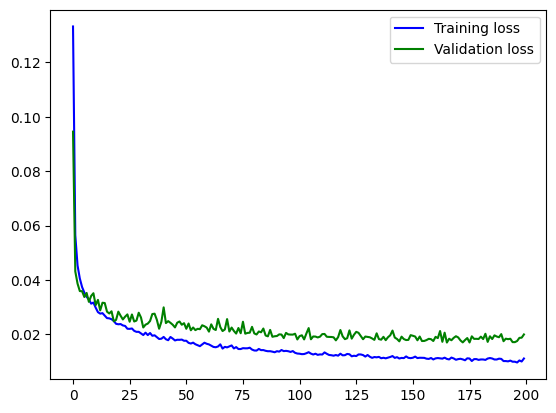

In [ ]:
plt.plot(np.arange(loss_hist.shape[0]), loss_hist, "b", label="Training loss")
plt.plot(np.arange(loss_hist_val.shape[0]), loss_hist_val, "g", label="Validation loss")
plt.legend()
plt.show()

You should see a curve that goes down for ca. 40 epochs, and then starts to flatten out. In the last part, it's still slowly decreasing, and most importantly, the validation loss is not increasing. This would be a certain sign of overfitting, and something that we should avoid. (Try decreasing the amount of training data artificially, then you should be able to intentionally cause overfitting.)

Note that the validation loss is generally higher above, as the dataset here is relatively small. At some point, the network will not be able to get new information from it that transfers to the validation samples.

A general word of caution here: never evaluate your network with training data. That won't tell you much because overfitting is a very common problem. At least use data the network hasn't seen before, i.e. validation data, and if that looks good, try some more different (at least slightly out-of-distribution) inputs, i.e., _test data_. The next cell runs the trained network on a batch of samples from the validation data, and displays one with the `plot` function.



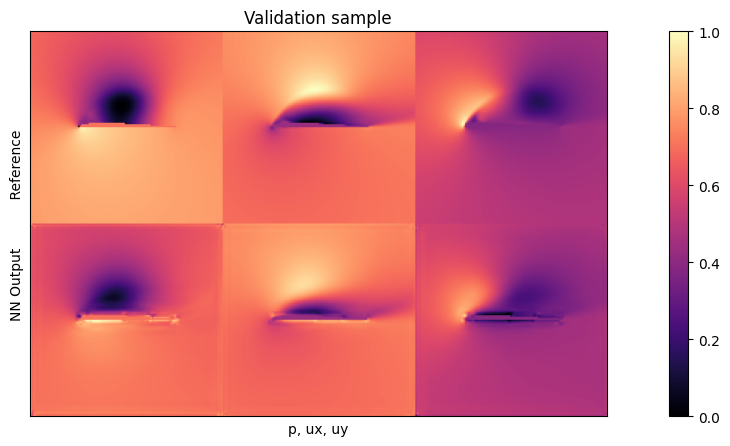

In [10]:
net.eval()
inputs, targets = next(iter(loader_val))
inputs = inputs.float()
targets = targets.float()

outputs = net(inputs)

outputs = outputs.data.cpu().numpy()
inputs = inputs.cpu()
targets = targets.cpu()
plot(targets[0], outputs[0], mask=inputs[0][2], title="Validation sample")

This shows a good resemblance here between input out network output. The region around the airfoil is typically still a bit noisy (this is caused by the Dirichlet boundary, and could be alleviated with a modified loss and larger networks). The pressure values are typically the most difficult ones to learn. We'll save the more detailed evaluation for the test data, though.

## Test evaluation

Now let's look at actual test samples: In this case we'll use new airfoil shapes as out-of-distribution (OOD) data. These are shapes that the network has not seen in any training samples, and hence it tells us a bit about how well the NN generalizes to unseen inputs (the validation data wouldn't suffice to draw conclusions about generalization).

We'll use the same visualization as before, and as indicated by the Bernoulli equation, especially the _pressure_ in the first column is a challenging quantity for the network. Due to it's cubic scaling w.r.t. the input freestream velocity and localized peaks, it is the toughest quantity to infer for the network.

The cell below first downloads a smaller archive with these test data samples, and then runs them through the network. The evaluation loop also computes the accumulated L1 error such that we can quantify how well the network does on the test samples.

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%
Success: Loaded airfoils-test with 10 simulations and 1 samples each.


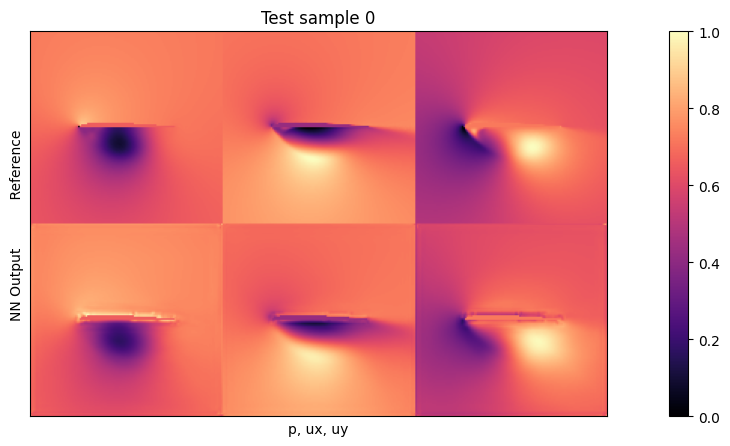

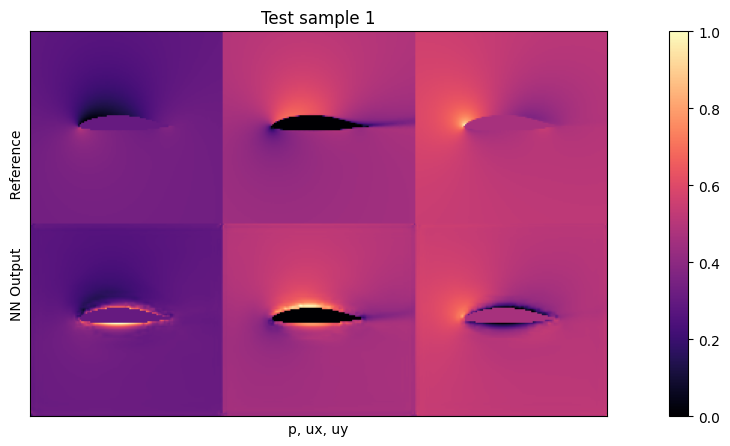

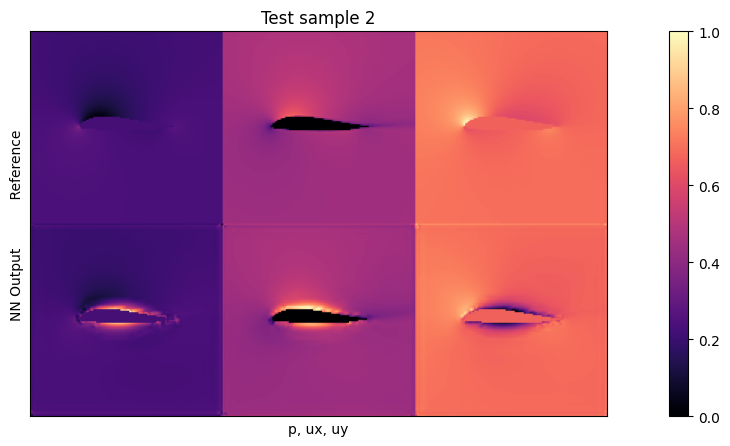


Average relative test error: 0.04200707469135523


In [11]:
loader_test = Dataloader( "airfoils-test", batch_size=1, normalize_data=None, shuffle=False )
loss = nn.L1Loss()

net.eval()
L1t_accum = 0.
for i, testdata in enumerate(loader_test, 0):
    inputs_curr, targets_curr = testdata
    inputs = inputs_curr.float()
    targets = targets_curr.float()

    outputs = net(inputs)

    outputs_curr = outputs.data.cpu().numpy()
    inputs_curr = inputs_curr.cpu()
    targets_curr = targets_curr.cpu()

    L1t_accum += loss(outputs, targets).item()
    if i<3: plot(targets_curr[0] , outputs_curr[0], mask=inputs_curr[0][2], title="Test sample %d"%(i))

print("\nAverage relative test error: {}".format( L1t_accum/len(loader_test) ))

The average test error with the default settings should be close to 0.025. As the inputs are normalized, this means the average relative error across all three fields is around 2.5% w.r.t. the maxima of each quantity. This is not too bad for new shapes, but clearly leaves room for improvement.

Looking at the visualizations, you'll notice that especially high-pressure peaks and pockets of larger y-velocities are missing in the outputs. This is primarily caused by the small network, which does not have enough resources to reconstruct details. The $L^2$ also has an averaging behavior, and favours larger structures (the surroundings) over localized peaks.

Nonetheless, we have successfully replaced a fairly sophisticated RANS solver with a small and fast neural network architecture. It has GPU support "out-of-the-box" (via pytorch), is differentiable, and introduces an error of only a few per-cent. With additional changes and more data, this setup can be made highly accurate {cite}`chen2021highacc`.

---




## Next steps

There are many obvious things to try here (see the suggestions below), e.g. longer training, larger data sets, larger networks etc.

* Experiment with learning rate, dropout, and network size to reduce the error on the test set. How small can you make it with the given training data?

* The setup above uses normalized data. Instead you can recover [the original fields by undoing the normalization](https://github.com/thunil/Deep-Flow-Prediction) to check how well the network does w.r.t. the original quantities.

* As you'll see, it's a bit limited here what you can get out of this dataset, head over to [the main github repo of this project](https://github.com/thunil/Deep-Flow-Prediction) to download larger data sets, or generate own data.

